We'll be using the Kaggle dataset API to download our images and Google Drive to store them, so the first several lines are just a bit of maintenance and prep work do that.

# **Business Problem**


  A hospital is looking to purchase updated X-ray machines. As a sales rep for, let's say GE, I'm pitching our latest model that utilizes machine learning to streamline the diagnostic process. Here I detail how our machine detects, classifies, and diagnoses pneumonia from chest X-rays. 

# **Data Understanding**

  The data consists of 5,856 X-ray images taken from Guangzhou Women's and Children's hospital. They are organized into three folders--train, test, and val--each with subfolders 'pneumonia' and 'normal'. The former contains chest xrays from pediatric patients diagnosed with pneumonia, while the latter from patients with normal xrays.

# **Data Import and Preprocessing**
  We'll be using the Kaggle dataset API to download our images and Google Drive to store them, so the first several lines are just a bit of maintenance and prep work do that. We performed our work in Google Colab, as it offers hosted GPUs that make CNN training much, much faster, and some of that prep work is also contained in the first few lines.



In [1]:
 # Install Kaggle API
! pip install -q kaggle

In [2]:
# Upload authentication token 
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mcn9284","key":"86a8a5f625a901c2d5e685a9c20c777f"}'}

In [3]:
# Creating a directory for the dataset and downloading it from Kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


 99% 2.28G/2.29G [00:10<00:00, 214MB/s]
100% 2.29G/2.29G [00:10<00:00, 236MB/s]


In [6]:
# Unzip the file 
! unzip chest-xray-pneumonia.zip && rm chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [7]:
# Importing necessary libraries
import os
import cv2
import glob
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomContrast, RandomBrightness, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [8]:
# Mounting Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


**Data Understanding**

Our data is stored in directory "chest x_ray" and is further subdivided into three subdirectories--train, val, and test. Each of those is further divided into 'NORMAL' and 'PNEUMONIA' folders. The data itself consists of jpeg images of X-Rays from both patients with and without pneumonia.

Generally speaking, pneumonia presents on radiograph as areas of diffuse opacity (sometimes called 'ground glass opacity') which represents areas of fluid accumulation in and around the alveoli. This fluid is created by the immune system in an attempt to rid the body of the bacterial or viral invader, and has the unfortunate side-effect of lowering the lungs' ability to exchange oxygen and carbon dioxide. Needless to say, not a good thing.

Our task is to create a convoluted neural network that can read these radiographs and classify them into either 'normal' or 'pneumonia' categories.

In [9]:
# Path to data
from pathlib import Path
data_dir = Path('chest_xray/')

# Path to train directory 
train_dir = data_dir/ 'train'

# Path to validation directory
val_dir =  data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [10]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# List all normal and pneumonia images 
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# Create empty list
train_data = []

# Label normal images 0
for img in normal_cases:
    train_data.append((img,0))

# Label pneumonia images 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Create dataframe with image and label data
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Inspect dataframe
train_data.head()

,image,label
0,chest_xray/train/PNEUMONIA/person293_virus_604...,1
1,chest_xray/train/PNEUMONIA/person1080_virus_17...,1
2,chest_xray/train/PNEUMONIA/person632_bacteria_...,1
3,chest_xray/train/NORMAL/IM-0256-0001.jpeg,0
4,chest_xray/train/PNEUMONIA/person13_bacteria_5...,1


Let's get a sense of what we're working with. First we will visualize our class balance, then we will take a look at several images from each class.

The images from each class definitely appear different, but there are some that, to the human eye, might be a bit unclear or hard to classify.

1    3875
0    1341
Name: label, dtype: int64


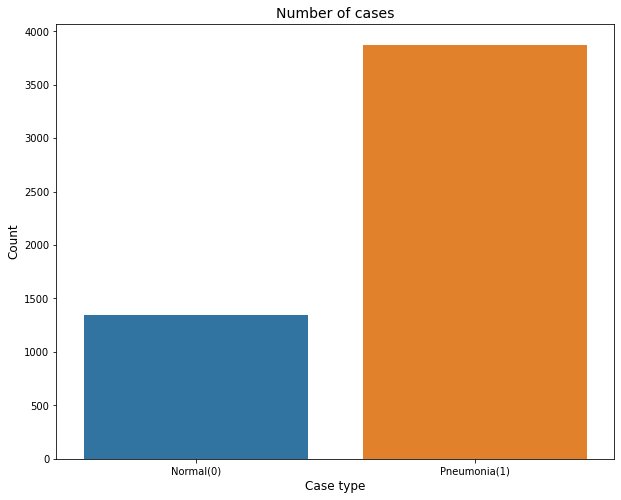

In [11]:
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

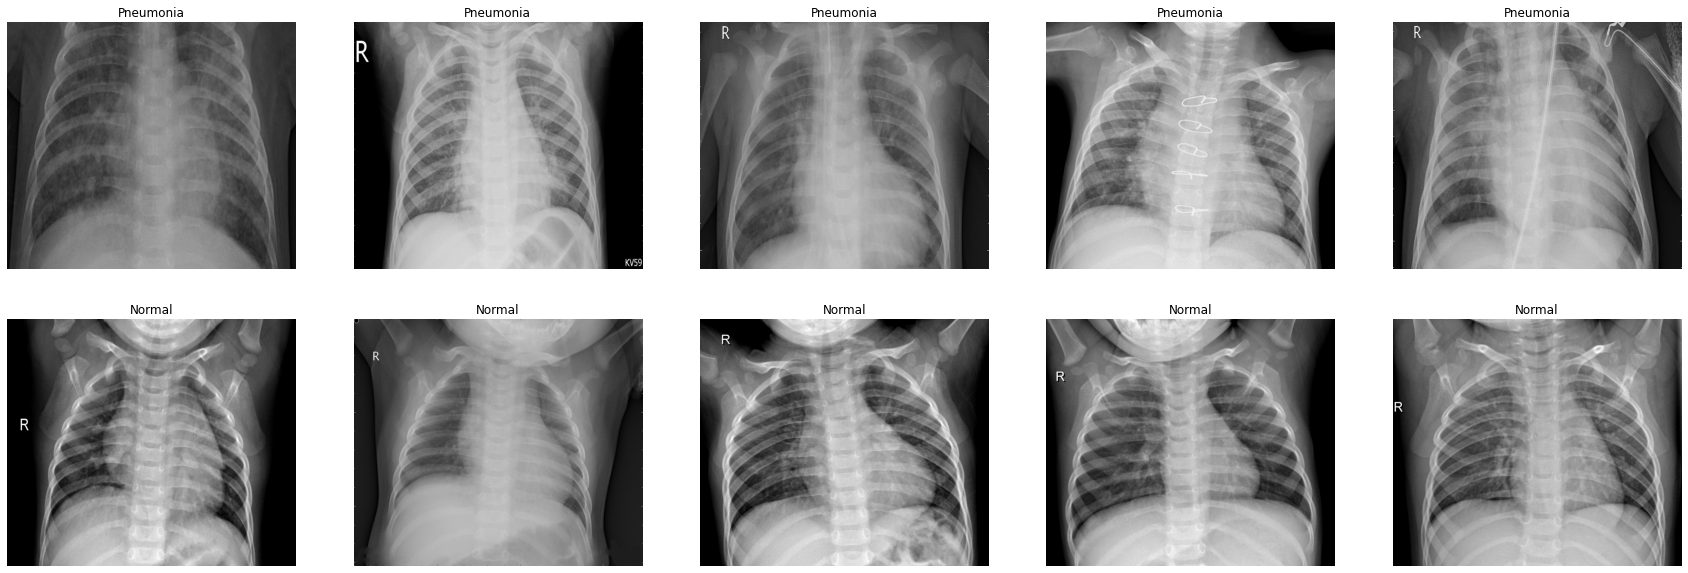

In [12]:
from skimage.io import imread

# Create lists of the first five rows in each class
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concatenate and delete the two lists
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

There are definite differences between the two classes visually, with pneumonia xrays showing the characteristic 'ground glass opacity'. There are a few cases that, at least to the untrained eye, appear to be ambiguous. Hopefully our model can pick up on features we can't.

Next we generate image tensor data from each of the image directories using ImageDataGenerator. This method can also be used for image augmentation, but we will be doing that as a preprocessing layer during modeling, so here we're just getting at the tensor data.

In [13]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir,
    batch_size=5216)
                                     
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    batch_size=624)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    batch_size=16)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Now we split the data into X, y splits calling next on our generators. As we can see from our above generators, the data split leaves us with rather few validation images. So we're going to combine all three tranches and then re=divide them into more manageable splits.

We will use a standard 20% split for each subset. We will train on the training splits, validate with the validation split, and test on the testing split.

In [14]:
train_img, train_labels = next(train_generator)
test_img, test_labels = next(test_generator)
val_img, val_labels = next(val_generator)

In [15]:
# Reshape the labels data
tr_y = np.reshape(train_labels[:,0], (5216,1))
te_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

In [99]:
class_weights = {0:1.85, 1:0.69}

In [29]:
X = np.concatenate((train_img, test_img, val_img))
y = np.concatenate((tr_y, te_y, val_y))

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.80, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.50, shuffle=True, random_state=42)

In [31]:
print("Total Training Samples: ", X_train.shape)
print("Total Validation Samples: ", X_val.shape)
print("Total Test Samples: ", X_test.shape)

Total Training Samples:  (4684, 256, 256, 3)
Total Validation Samples:  (586, 256, 256, 3)
Total Test Samples:  (586, 256, 256, 3)


# **Modeling**
We start with a baseline CNN consisting of one convolution layer with eight five-by-five filters, and relu activation, followed by a pooling layer.
These are then flattened and fed to the 32 unit dense layer before output with sigmoid activation.



In [37]:
baseline = keras.Sequential()

baseline.add(layers.Conv2D(8,(5,5),input_shape=(256,256,3), activation='relu'))
baseline.add(layers.MaxPooling2D(2,2))

baseline.add(layers.Flatten())
baseline.add(layers.Dense(32, activation='relu'))
baseline.add(layers.Dense(1, activation='sigmoid'))

baseline.compile(loss='binary_crossentropy',
                 optimizer=keras.optimizers.Adam(),
                 metrics=['accuracy'])

In [ ]:
baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 8)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 32)                4064288   
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,064,929
Trainable params: 4,064,929
Non-trainable params: 0
______________________________________________

In [38]:
history_0 = baseline.fit(X_train,
                         y_train,
                         shuffle=True,
                         epochs=20,
                         batch_size=32,
                         validation_data=(X_val, y_val),
                         verbose=1)

Epoch 1/20
147/147 [==============================] - 12s 18ms/step - loss: 0.6291 - accuracy: 0.7088 - val_loss: 0.2870 - val_accuracy: 0.7662
Epoch 2/20
147/147 [==============================] - 2s 12ms/step - loss: 0.3057 - accuracy: 0.8602 - val_loss: 0.2404 - val_accuracy: 0.9403
Epoch 3/20
147/147 [==============================] - 2s 12ms/step - loss: 0.2711 - accuracy: 0.9338 - val_loss: 0.2105 - val_accuracy: 0.9590
Epoch 4/20
147/147 [==============================] - 2s 12ms/step - loss: 0.2451 - accuracy: 0.9436 - val_loss: 0.2008 - val_accuracy: 0.9590
Epoch 5/20
147/147 [==============================] - 2s 12ms/step - loss: 0.2233 - accuracy: 0.9500 - val_loss: 0.1899 - val_accuracy: 0.9573
Epoch 6/20
147/147 [==============================] - 2s 12ms/step - loss: 0.2009 - accuracy: 0.9579 - val_loss: 0.1839 - val_accuracy: 0.9539
Epoch 7/20
147/147 [==============================] - 2s 12ms/step - loss: 0.1901 - accuracy: 0.9624 - val_loss: 0.1749 - val_accuracy: 0.955

The following two functions help us evaluate model performance. The first plots the training and validation loss and accuracy curves, while the second generates a confusion matrix for the validation/test datasets.

In [39]:
def learn_curves(history):
   #get history of model
  history_dict = history.history
    
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # define accruacy and loss values
  acc_values = history_dict['accuracy'] 
  val_acc_values = history_dict['val_accuracy'] 
  loss_values = history_dict['loss'] 
  val_loss_values = history_dict['val_loss']
     
    # set x range    
  epochs = range(1, len(acc_values) + 1)
    
    # plot accuracy for training and validation
  ax[0].plot(epochs, acc_values, label='Training acc')
  ax[0].plot(epochs, val_acc_values, label='Validation acc')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend();
    
    # plot loss for training and validation
  ax[1].plot(epochs, loss_values, label='Training loss')
  ax[1].plot(epochs, val_loss_values, label='Validation loss')
  ax[1].set_title('Training & Validation Loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend();
    
  print("Final Training Accuracy:", acc_values[-1])
  print("Final Validation Accuracy:", val_acc_values[-1])

In [220]:
def evaluation(model):
  predictions = (model.predict(X_val) > 0.5)*1
  cm = confusion_matrix(y_val, predictions)

  df_cm = pd.DataFrame(cm.T, index=['Pneumonia','Normal'],
                       columns=['Pneumonia','Normal'])
  sns.heatmap(df_cm.T, annot=True, fmt='d', cmap='YlGnBu', linecolor='black', linewidths=1)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.ylim(0,2)
  plt.xlim(2,0)
  plt.show();

  print(model.evaluate(X_val,y_val))

Final Training Accuracy: 0.9967976212501526
Final Validation Accuracy: 0.9539248943328857


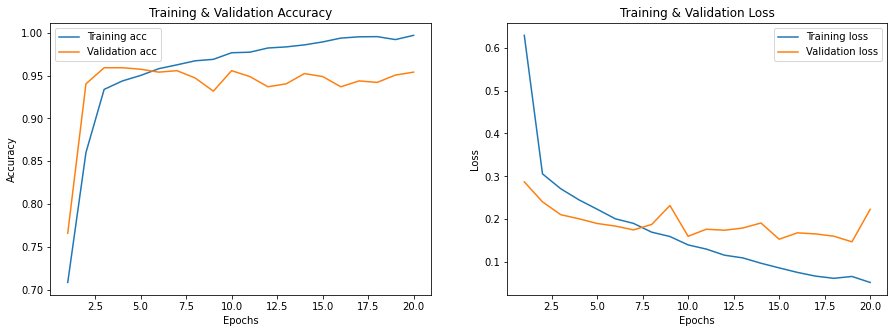

In [221]:
learn_curves(history_0)

19/19 [==============================] - 0s 8ms/step


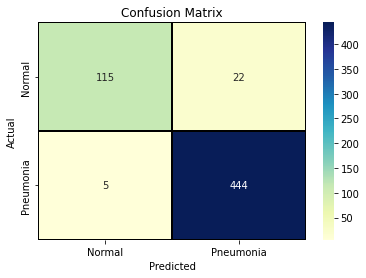

19/19 [==============================] - 0s 9ms/step - loss: 0.2229 - accuracy: 0.9539
[0.22292429208755493, 0.9539248943328857]


In [222]:
evaluation(baseline)

These are great results right off the bat, but lets see if we can do better.

We're adding a pre-processing layer to randomly alter the images' contrast. Given the nature of the Xrays and diagnosis, altering contrast may draw out features that could otherwise be overlooked(?).

The rest of the model is the same.

In [67]:
model_1 = keras.Sequential()

model_1.add(layers.experimental.preprocessing.RandomContrast([0,1]))

model_1.add(layers.Conv2D(8,(5,5),input_shape=(256,256,3), kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model_1.add(layers.MaxPooling2D(2,2))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(32, activation='relu'))
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy',
                 optimizer=keras.optimizers.Adam(),
                 metrics=['accuracy'])

In [68]:
history_1 = model_1.fit(X_train,
                        y_train,
                        shuffle=True,
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        verbose=1)

Epoch 1/20


147/147 [==============================] - 16s 95ms/step - loss: 0.4728 - accuracy: 0.8164 - val_loss: 0.2592 - val_accuracy: 0.8942
Epoch 2/20
147/147 [==============================] - 14s 91ms/step - loss: 0.2627 - accuracy: 0.9400 - val_loss: 0.2681 - val_accuracy: 0.9573
Epoch 3/20
147/147 [==============================] - 13s 92ms/step - loss: 0.2364 - accuracy: 0.9498 - val_loss: 0.2068 - val_accuracy: 0.9505
Epoch 4/20
147/147 [==============================] - 13s 91ms/step - loss: 0.2092 - accuracy: 0.9577 - val_loss: 0.2148 - val_accuracy: 0.9266
Epoch 5/20
147/147 [==============================] - 13s 91ms/step - loss: 0.1940 - accuracy: 0.9609 - val_loss: 0.1944 - val_accuracy: 0.9505
Epoch 6/20
147/147 [==============================] - 14s 92ms/step - loss: 0.1727 - accuracy: 0.9665 - val_loss: 0.1809 - val_accuracy: 0.9471
Epoch 7/20
147/147 [==============================] - 13s 92ms/step - loss: 0.1593 - accuracy: 0.9712 - val_loss: 0.2175 - val_accuracy: 0.9386
Epo

Final Training Accuracy: 0.9974380731582642
Final Validation Accuracy: 0.9505119323730469


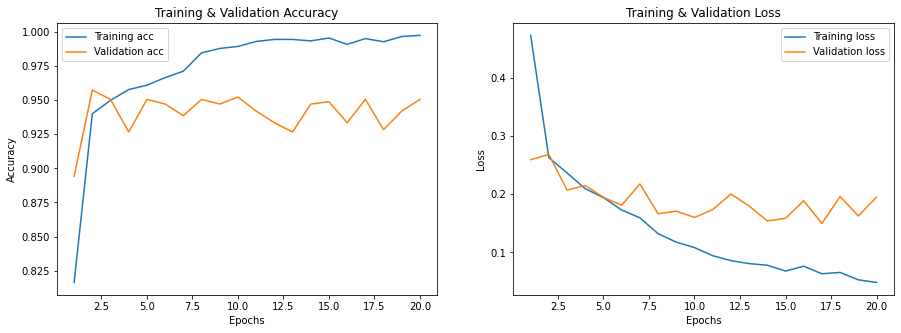

In [223]:
learn_curves(history_1)

19/19 [==============================] - 0s 8ms/step


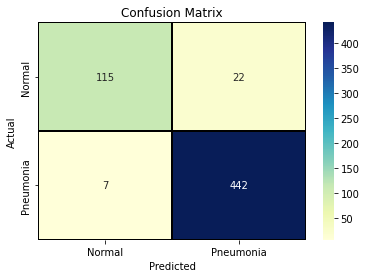

19/19 [==============================] - 0s 9ms/step - loss: 0.1950 - accuracy: 0.9505
[0.19495424628257751, 0.9505119323730469]


In [224]:
evaluation(model_1)

The baseline models are overfit. Our next iteration will increase the complexity by adding another convolution and pooling layer

In [85]:
model_2 = keras.Sequential()

model_2.add(layers.experimental.preprocessing.RandomContrast([0.2,0.8]))

model_2.add(layers.Conv2D(8, (5,5), input_shape=(256,256,3), kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model_2.add(layers.MaxPooling2D((2,2)))

model_2.add(layers.Conv2D(16, (3,3), kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model_2.add(layers.MaxPooling2D(2,2))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.compile(loss='binary_crossentropy',
                 optimizer=keras.optimizers.Adam(1e-5),
                 metrics=['accuracy'])

In [86]:
model_2.build(input_shape=(None,256,256,3))
model_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast_10 (RandomC  (None, 256, 256, 3)      0         
 ontrast)                                                        
                                                                 
 conv2d_15 (Conv2D)          (None, 252, 252, 8)       608       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 126, 126, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 124, 124, 16)      1168      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                            
                                                     

In [87]:
history_2 = model_2.fit(X_train,
                        y_train,
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        shuffle=True,
                        verbose=1)

Epoch 1/20


147/147 [==============================] - 15s 94ms/step - loss: 0.5901 - accuracy: 0.7831 - val_loss: 0.4803 - val_accuracy: 0.8754
Epoch 2/20
147/147 [==============================] - 14s 92ms/step - loss: 0.3947 - accuracy: 0.8890 - val_loss: 0.3818 - val_accuracy: 0.8840
Epoch 3/20
147/147 [==============================] - 14s 92ms/step - loss: 0.3176 - accuracy: 0.9216 - val_loss: 0.3233 - val_accuracy: 0.9130
Epoch 4/20
147/147 [==============================] - 13s 92ms/step - loss: 0.2770 - accuracy: 0.9332 - val_loss: 0.3087 - val_accuracy: 0.9096
Epoch 5/20
147/147 [==============================] - 13s 91ms/step - loss: 0.2512 - accuracy: 0.9436 - val_loss: 0.2693 - val_accuracy: 0.9505
Epoch 6/20
147/147 [==============================] - 13s 92ms/step - loss: 0.2362 - accuracy: 0.9434 - val_loss: 0.2423 - val_accuracy: 0.9471
Epoch 7/20
147/147 [==============================] - 14s 92ms/step - loss: 0.2254 - accuracy: 0.9481 - val_loss: 0.2323 - val_accuracy: 0.9522
Epo

Final Training Accuracy: 0.9637062549591064
Final Validation Accuracy: 0.9505119323730469


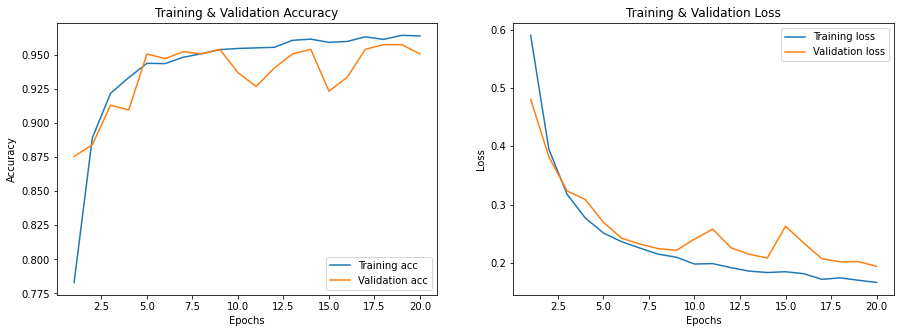

In [225]:
learn_curves(history_2)

19/19 [==============================] - 0s 8ms/step


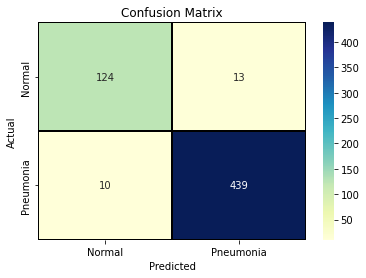

19/19 [==============================] - 0s 9ms/step - loss: 0.1797 - accuracy: 0.9608
[0.17969942092895508, 0.9607508778572083]


In [226]:
evaluation(model_2)

Our false positives have gone down a bit, but in this case is not the end of the world. For medical problems, false positives are preferable to false negatives.

The learning curve plot shows that we're still overfitting, but to a much lesser degree.

In [97]:
model_3 = keras.Sequential()
model_3.add(layers.experimental.preprocessing.RandomContrast([0.2,0.8]))

model_3.add(layers.Conv2D(8, (5,5), kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(256,256,3))),
model_3.add(layers.Conv2D(16, (5,5), activation='relu')),
model_3.add(layers.MaxPooling2D(2,2)),

model_3.add(layers.Conv2D(32, (3,3),kernel_regularizer=regularizers.l2(0.001), activation='relu')),
model_3.add(layers.Conv2D(64, (3,3), activation='relu')),
model_3.add(layers.MaxPooling2D(2,2)),

model_3.add(layers.Flatten()),
model_3.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu')),
model_3.add(layers.Dropout(0.4)),
model_3.add(layers.Dense(1, activation='sigmoid')),

model_3.compile(loss='binary_crossentropy',
                 optimizer=keras.optimizers.Adam(1e-5),
                 metrics=['accuracy'])

In [100]:
history_3 = model_3.fit(X_train,
                        y_train,
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        shuffle=True,
                        class_weight=class_weights,
                        verbose=1)

Epoch 1/20


147/147 [==============================] - 19s 109ms/step - loss: 0.7816 - accuracy: 0.7240 - val_loss: 0.6501 - val_accuracy: 0.7662
Epoch 2/20
147/147 [==============================] - 16s 106ms/step - loss: 0.5430 - accuracy: 0.7707 - val_loss: 0.4768 - val_accuracy: 0.7986
Epoch 3/20
147/147 [==============================] - 15s 105ms/step - loss: 0.4299 - accuracy: 0.8386 - val_loss: 0.4155 - val_accuracy: 0.8430
Epoch 4/20
147/147 [==============================] - 16s 106ms/step - loss: 0.3680 - accuracy: 0.8813 - val_loss: 0.3587 - val_accuracy: 0.8891
Epoch 5/20
147/147 [==============================] - 16s 106ms/step - loss: 0.3280 - accuracy: 0.9073 - val_loss: 0.4113 - val_accuracy: 0.8498
Epoch 6/20
147/147 [==============================] - 15s 105ms/step - loss: 0.3007 - accuracy: 0.9208 - val_loss: 0.2738 - val_accuracy: 0.9317
Epoch 7/20
147/147 [==============================] - 15s 105ms/step - loss: 0.2847 - accuracy: 0.9283 - val_loss: 0.3222 - val_accuracy: 0.9

Final Training Accuracy: 0.951750636100769
Final Validation Accuracy: 0.9436860084533691


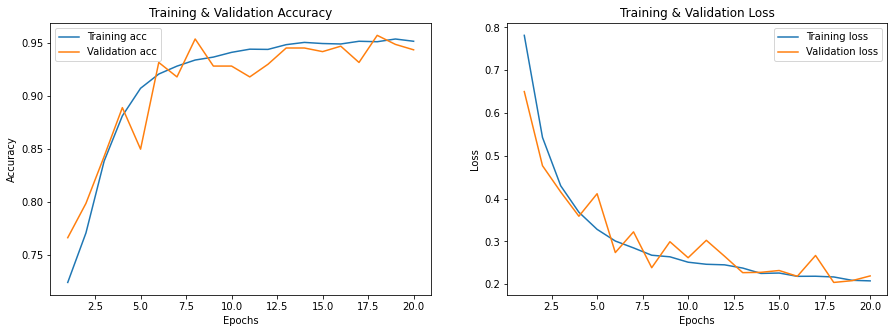

In [227]:
learn_curves(history_3)

19/19 [==============================] - 0s 11ms/step


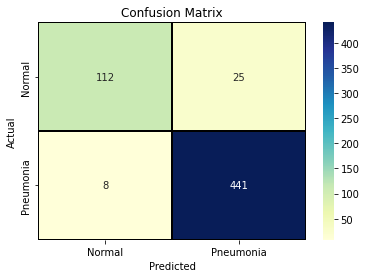

19/19 [==============================] - 0s 12ms/step - loss: 0.2192 - accuracy: 0.9437
[0.21916159987449646, 0.9436860084533691]


In [228]:
evaluation(model_3)

We've reduced the false negatives a bit, and our accuracy looks good. But we're overfitting still and I think it's time to address that.

lets leave the architecture alone while increasing the filters and reducing the learning rate. We will also introduce two dropout layers. This controls overfitting by turning off a percentage of neurons in a given layer, preventing the model from learning unnecessary patterns.

In [231]:
model_4 = keras.Sequential()
model_4.add(layers.experimental.preprocessing.RandomContrast([0.2,0.8]))

model_4.add(layers.Conv2D(32, (5,5),kernel_regularizer=regularizers.l2(0.001), activation='relu')),
model_4.add(layers.Conv2D(64, (3,3), activation='relu'))
model_4.add(layers.MaxPooling2D(2,2))

model_4.add(layers.Conv2D(128, (3,3),kernel_regularizer=regularizers.l2(0.001), activation='relu')),
model_4.add(layers.Conv2D(256, (3,3), activation='relu'))
model_4.add(layers.Dropout(.25))
model_4.add(layers.MaxPooling2D(2,2))

model_4.add(layers.Flatten())
model_4.add(layers.Dense(512,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model_4.add(layers.Dropout(0.4))
model_4.add(layers.Dense(1, activation='sigmoid'))

model_4.compile(loss='binary_crossentropy',
                 optimizer=keras.optimizers.Adam(1e-6),
                 metrics=['accuracy'])

In [232]:
model_4.build(input_shape=(None, 256, 256, 3))
model_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast_1 (RandomCo  (None, 256, 256, 3)      0         
 ntrast)                                                         
                                                                 
 conv2d_6 (Conv2D)           (None, 252, 252, 32)      2432      
                                                                 
 conv2d_7 (Conv2D)           (None, 250, 250, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 125, 125, 64)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 123, 123, 128)     73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 121, 121, 256)    

In [233]:
history_4 = model_4.fit(X_train,
                        y_train,
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        shuffle=True,
                        class_weight=class_weights,
                        verbose=1)

Epoch 1/20


147/147 [==============================] - 30s 173ms/step - loss: 1.6289 - accuracy: 0.7248 - val_loss: 1.5088 - val_accuracy: 0.7662
Epoch 2/20
147/147 [==============================] - 25s 168ms/step - loss: 1.4080 - accuracy: 0.7376 - val_loss: 1.3403 - val_accuracy: 0.7662
Epoch 3/20
147/147 [==============================] - 25s 169ms/step - loss: 1.2485 - accuracy: 0.8006 - val_loss: 1.2183 - val_accuracy: 0.7901
Epoch 4/20
147/147 [==============================] - 25s 168ms/step - loss: 1.1311 - accuracy: 0.8442 - val_loss: 1.1058 - val_accuracy: 0.8464
Epoch 5/20
147/147 [==============================] - 25s 168ms/step - loss: 1.0387 - accuracy: 0.8704 - val_loss: 1.0140 - val_accuracy: 0.8942
Epoch 6/20
147/147 [==============================] - 25s 169ms/step - loss: 0.9611 - accuracy: 0.8836 - val_loss: 0.9748 - val_accuracy: 0.8481
Epoch 7/20
147/147 [==============================] - 25s 169ms/step - loss: 0.8933 - accuracy: 0.9009 - val_loss: 0.8832 - val_accuracy: 0.9

Final Training Accuracy: 0.9397950172424316
Final Validation Accuracy: 0.9334471225738525


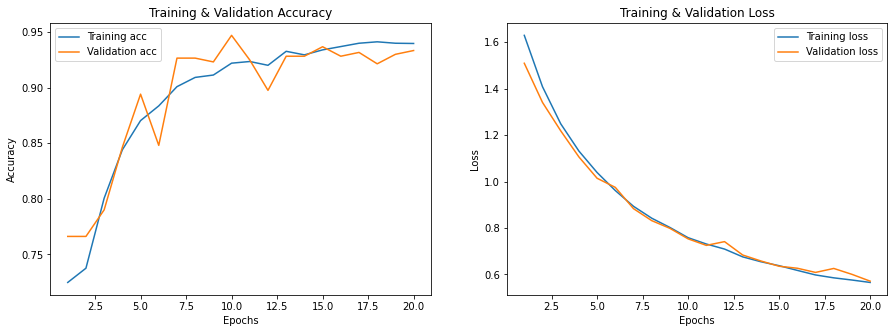

In [234]:
learn_curves(history_4)

19/19 [==============================] - 1s 22ms/step


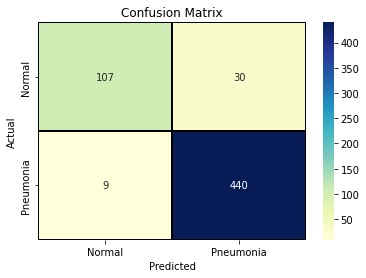

19/19 [==============================] - 1s 27ms/step - loss: 0.5713 - accuracy: 0.9334
[0.5712720155715942, 0.9334471225738525]


In [235]:
evaluation(model_4)

Quite a difference. 

We tuned the learning rate of the optimizer by an order of magnitude and added two dropouts. The result is greatly reduced overfit and a noticeable bump in false positives.

False positives here, again, are not as much of an issue since we'd rather have those than false negatives.

We will next introduce batch normalization to help stabilize the model. This works by re-normalizing the distribution of input information--small changes in said distribution can build up over model runs.

In [108]:
model_5 = models.Sequential()

model_5.add(layers.experimental.preprocessing.RandomContrast([0.2,0.8])),

model_5.add(layers.Conv2D(8, (5,5), activation='relu', input_shape=(256,256,3))),
model_5.add(layers.BatchNormalization()),
model_5.add(layers.Conv2D(16, (3,3), activation='relu', 
                          kernel_regularizer=regularizers.l2(0.001)))
model_5.add(layers.MaxPooling2D(2,2)),

model_5.add(layers.Conv2D(32, (3,3), activation='relu')),
model_5.add(layers.BatchNormalization()),
model_5.add(layers.Conv2D(64, (3,3), activation='relu', 
                          kernel_regularizer=regularizers.l2(0.001)))
model_5.add(layers.MaxPooling2D(2,2))

model_5.add(layers.Conv2D(128, (3,3), activation='relu')),
model_5.add(layers.BatchNormalization()),
model_5.add(layers.Conv2D(256, (3,3), activation='relu', 
                          kernel_regularizer=regularizers.l2(0.001)))
model_5.add(layers.MaxPooling2D((2,2))),

model_5.add(layers.Flatten()),
model_5.add(layers.Dense(512, activation='relu')),
model_5.add(layers.Dropout(.5)),
model_5.add(layers.Dense(1, activation='sigmoid')),

model_5.compile(loss='binary_crossentropy',
                 optimizer=keras.optimizers.Adam(1e-6),
                 metrics=['accuracy'])

In [109]:
model_5.build(input_shape=(None,256,256,3))
model_5.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast_16 (RandomC  (None, 256, 256, 3)      0         
 ontrast)                                                        
                                                                 
 conv2d_28 (Conv2D)          (None, 252, 252, 8)       608       
                                                                 
 batch_normalization (BatchN  (None, 252, 252, 8)      32        
 ormalization)                                                   
                                                                 
 conv2d_29 (Conv2D)          (None, 250, 250, 16)      1168      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 125, 125, 16)     0         
 g2D)                                                            
                                                     

In [110]:
history_5 = model_5.fit(X_train,
                        y_train,
                        epochs=20,
                        batch_size=32,
                        shuffle=True,
                        class_weight=class_weights,
                        validation_data=(X_val, y_val),
                        verbose=1)

Epoch 1/20


147/147 [==============================] - 20s 121ms/step - loss: 0.5984 - accuracy: 0.8284 - val_loss: 0.7870 - val_accuracy: 0.7662
Epoch 2/20
147/147 [==============================] - 17s 115ms/step - loss: 0.4317 - accuracy: 0.9099 - val_loss: 0.8046 - val_accuracy: 0.7662
Epoch 3/20
147/147 [==============================] - 17s 115ms/step - loss: 0.3982 - accuracy: 0.9285 - val_loss: 0.8947 - val_accuracy: 0.7662
Epoch 4/20
147/147 [==============================] - 17s 115ms/step - loss: 0.3728 - accuracy: 0.9389 - val_loss: 0.5076 - val_accuracy: 0.8618
Epoch 5/20
147/147 [==============================] - 17s 115ms/step - loss: 0.3469 - accuracy: 0.9485 - val_loss: 0.3717 - val_accuracy: 0.9317
Epoch 6/20
147/147 [==============================] - 17s 115ms/step - loss: 0.3351 - accuracy: 0.9567 - val_loss: 0.3433 - val_accuracy: 0.9522
Epoch 7/20
147/147 [==============================] - 17s 115ms/step - loss: 0.3347 - accuracy: 0.9588 - val_loss: 0.3303 - val_accuracy: 0.9

Final Training Accuracy: 0.9859094619750977
Final Validation Accuracy: 0.9505119323730469


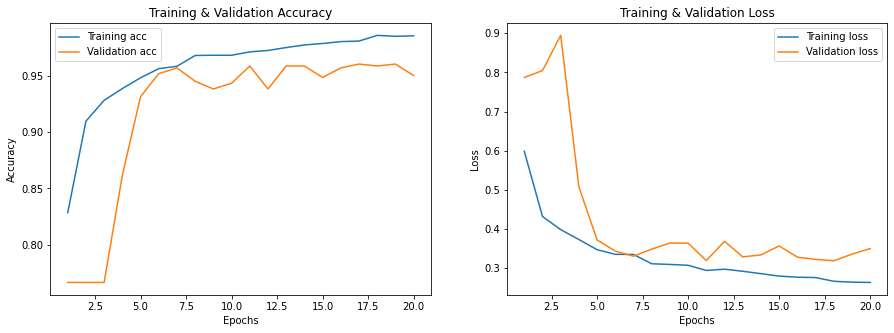

In [112]:
learn_curves(history_5)

Batch normalization doesn't go so well in between conv layers. Now we know that.

It doees make more sense to renormalize after convolutions and before we send the information off to the next round.

In [114]:
model_6 = models.Sequential([
layers.experimental.preprocessing.RandomContrast([0.2,0.8]),

layers.Conv2D(8, (5,5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(256,256,3)),
layers.Conv2D(16, (3,3)),
layers.BatchNormalization(axis=1),
layers.Activation('relu'),
layers.MaxPooling2D((2,2)),

layers.Conv2D(64, (3,3), kernel_regularizer=regularizers.l2(0.001), activation='relu'),
layers.Conv2D(128, (3,3)),
layers.BatchNormalization(axis=1),
layers.Activation('relu'),
layers.MaxPooling2D((2,2)),

layers.Conv2D(256, (3,3), kernel_regularizer=regularizers.l2(0.002), activation='relu'),
layers.Conv2D(256, (3,3)),
layers.BatchNormalization(axis=1),
layers.Activation('relu'),
layers.MaxPooling2D((2,2)),

layers.Flatten(),
layers.Dense(512, activation='relu'),
layers.Dropout(0.5),
layers.Dense(1, activation='sigmoid')

])

model_6.compile(loss='binary_crossentropy',
                 optimizer=keras.optimizers.Adam(1e-6),
                 metrics=['accuracy'])



In [115]:
model_6.build(input_shape=(None, 256, 256, 3))
model_6.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast_17 (RandomC  (None, 256, 256, 3)      0         
 ontrast)                                                        
                                                                 
 conv2d_34 (Conv2D)          (None, 252, 252, 8)       608       
                                                                 
 conv2d_35 (Conv2D)          (None, 250, 250, 16)      1168      
                                                                 
 batch_normalization_3 (Batc  (None, 250, 250, 16)     1000      
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 250, 250, 16)      0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 125, 125, 16)   

In [116]:
callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=3)

In [117]:
history_6 = model_6.fit(X_train,
                        y_train,
                        epochs=20,
                        batch_size=32,
                        shuffle=True,
                        class_weight=class_weights,
                        validation_data=(X_val, y_val),
                        #callbacks=callbacks,
                        verbose=1)

Epoch 1/20


147/147 [==============================] - 22s 130ms/step - loss: 0.8317 - accuracy: 0.7735 - val_loss: 0.9241 - val_accuracy: 0.7662
Epoch 2/20
147/147 [==============================] - 18s 125ms/step - loss: 0.6759 - accuracy: 0.8450 - val_loss: 0.7182 - val_accuracy: 0.8106
Epoch 3/20
147/147 [==============================] - 18s 125ms/step - loss: 0.6234 - accuracy: 0.8728 - val_loss: 0.6206 - val_accuracy: 0.8891
Epoch 4/20
147/147 [==============================] - 18s 124ms/step - loss: 0.5999 - accuracy: 0.8888 - val_loss: 0.6309 - val_accuracy: 0.8720
Epoch 5/20
147/147 [==============================] - 18s 124ms/step - loss: 0.5745 - accuracy: 0.9031 - val_loss: 0.5892 - val_accuracy: 0.8959
Epoch 6/20
147/147 [==============================] - 18s 125ms/step - loss: 0.5625 - accuracy: 0.9065 - val_loss: 0.6433 - val_accuracy: 0.8686
Epoch 7/20
147/147 [==============================] - 18s 125ms/step - loss: 0.5467 - accuracy: 0.9176 - val_loss: 0.5396 - val_accuracy: 0.9

Final Training Accuracy: 0.950042724609375
Final Validation Accuracy: 0.947098970413208


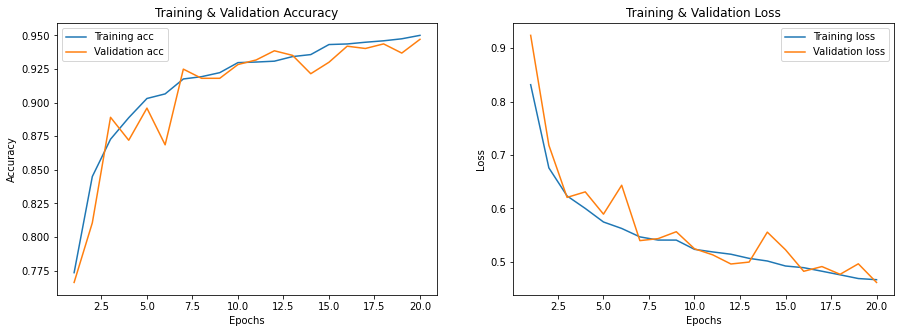

In [118]:
learn_curves(history_6)

In [215]:
keras.backend.clear_session()

That was a bust. Let's use only one batch normalization just before the final relu activation, and add another dense and dropout.

In [241]:
model_7 = models.Sequential([
layers.experimental.preprocessing.RandomContrast([0.2,0.8]),

layers.Conv2D(8, (5,5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(256,256,3)),
layers.Conv2D(16, (3,3)),
layers.BatchNormalization(),
layers.Activation('relu'),
layers.MaxPooling2D((2,2)),

layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(256,256,3)),
layers.Conv2D(64, (3,3)),
layers.BatchNormalization(),
layers.Activation('relu'),
layers.MaxPooling2D((2,2)),

layers.Conv2D(128, (3,3), activation='relu', input_shape=(256,256,3)),
layers.Conv2D(256, (3,3)),
layers.BatchNormalization(),
layers.Activation('relu'),
layers.MaxPooling2D((2,2)),

layers.Flatten(),
layers.Dense(512, activation='relu'),
layers.Dropout(0.5),
layers.Dense(512, activation='relu'),
layers.Dropout(0.4),
layers.Dense(1, activation='sigmoid')

])

model_7.compile(loss='binary_crossentropy',
                 optimizer=keras.optimizers.Adam(1e-5),
                 metrics=['accuracy'])

In [242]:
model_7.build(input_shape=(None, 256, 256, 3))
model_7.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast_4 (RandomCo  (None, 256, 256, 3)      0         
 ntrast)                                                         
                                                                 
 conv2d_22 (Conv2D)          (None, 252, 252, 8)       608       
                                                                 
 conv2d_23 (Conv2D)          (None, 250, 250, 16)      1168      
                                                                 
 batch_normalization_9 (Batc  (None, 250, 250, 16)     64        
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 250, 250, 16)      0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 125, 125, 16)    

In [243]:
history_7 = model_7.fit(X_train,
                          y_train,
                          epochs=20,
                          batch_size=32,
                          shuffle=True,
                          class_weight=class_weights,
                          validation_data=(X_val, y_val),
                          #callbacks=callbacks,
                          verbose=1)

InternalError: ignored

Final Training Accuracy: 0.9400085210800171
Final Validation Accuracy: 0.9249146580696106


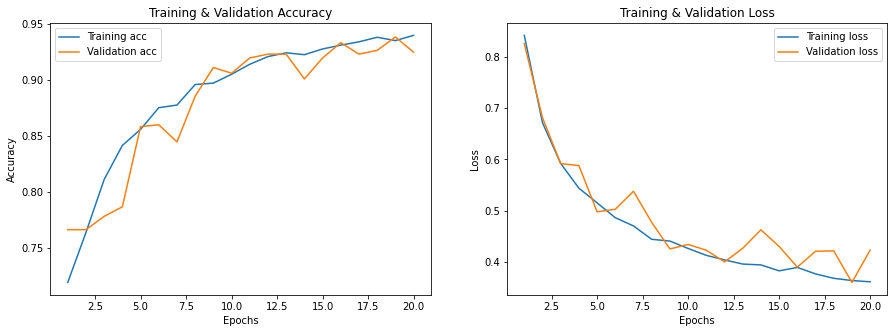

In [239]:
learn_curves(history_7)

Best performing model was model 7.

In [207]:
preds = np.where(model_7.predict(X_test) <= 0.4999, 0,1)
df = pd.DataFrame(preds)
df.value_counts()

19/19 [==============================] - 0s 14ms/step


0    457
1    129
dtype: int64

In [204]:
df2 = pd.DataFrame(y_test.T)
df2.value_counts()

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80   81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96   97   98   99   100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  

In [192]:
from sklearn.metrics import classification_report

In [203]:
print(classification_report(y_test.T, preds.T))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         0
           6       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         0
          17       1.00    

In [ ]:
len(y_val)

937

In [ ]:
model = keras.models.load_model('model.h5')

In [190]:
model.evaluate(X_train, y_train)

NameError: ignored

(1, 256, 256, 3)


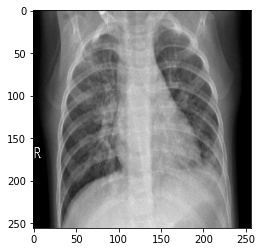

In [176]:
from keras.preprocessing import image
from keras.utils import load_img
import numpy as np
  
# Pre-processing the image
img = keras.utils.load_img('chest_xray/train/PNEUMONIA/person99_virus_183.jpeg', target_size = (256, 256))
img_tensor = keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor = img_tensor / 255.
  
# Print image tensor shape
print(img_tensor.shape)
  
# Print image
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [165]:
! pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 4.6 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=1b702e35080ce578fe0e54a4c29e9c7690ad427f413e16ae5287277255c55b47
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [177]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()


In [178]:
# get explaination instance for images
bacteria_explanation = explainer.explain_instance(img_tensor[0].astype('double'), model_7.predict, 
                                         top_labels=2, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


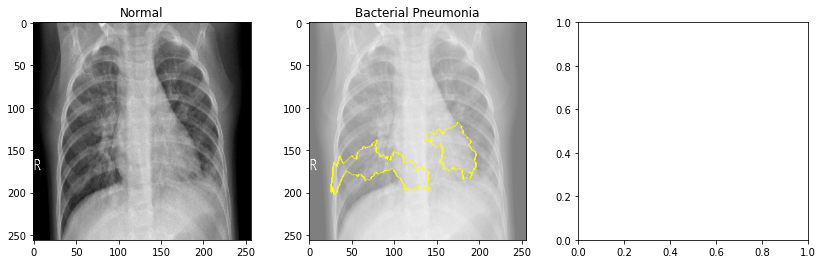

In [179]:
from skimage.segmentation import mark_boundaries

# plot bacteria and viral pneumonia explanations
fig, ax = plt.subplots(ncols=3, figsize=(14,4))

# get bacterial pneumonia explanation
bacteria_temp, bacteria_mask = bacteria_explanation.get_image_and_mask(
    bacteria_explanation.top_labels[0], positive_only= False, 
    negative_only=True, num_features=3, hide_rest=False)


# plot normal vs bacterial and viral pneumonia
ax[0].imshow(img_tensor[0]);
ax[0].set_title('Normal');
ax[1].imshow(mark_boundaries(bacteria_temp / 2 + 0.5, bacteria_mask));
ax[1].set_title('Bacterial Pneumonia');


TypeError: ignored

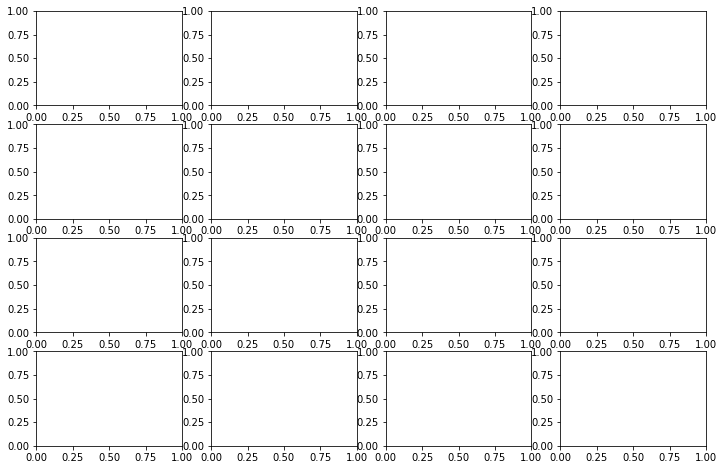

In [187]:
fig, axes = plt.subplots(4,4, figsize=(12,8))

layer_names = []
for layer in model_7.layers[:16]:
    layer_names.append(layer.name)

for i in range(4):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, -1], cmap='inferno')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])
plt.tight_layout(pad=2)